# Modelo

## Constantes

In [1]:
#NP = (110119 + 109164 + 111111) / 3 
NP = 110119 
A_TERR = 17.32 * NP / 3000

A_SOT = 8.66 ** 2                   # m2
Q_MAX = 8                           # m3/h
D_H_MAX = 3.5 # lo cambie           # m
D_H_MIN = 1                         # m
H_SOT = 3.50                        # m
V_SOT = H_SOT * A_SOT               # m3

C_SAT = 0.90                        # admin
C_0 = 0.60                          # admin

T_K = (1-NP/140000)                 # h


# EC 1
def f_der_v(q_ent, q_sal):
    return q_ent - q_sal

# EC 2
def f_q_ent(c, i, a_terr):
    return c * i * a_terr           # admin * m/h * m2 = m3/h

# EC 3
def f_q_sal(q_max, d_h_max, d_h_min, d_h):
    if d_h < d_h_min: return q_max
    return q_max * (((d_h_max - d_h)/(d_h_max - d_h_min)) ** 0.5)

# EC 4
def f_d_h(h_s, h):
    return h_s - h

# EC 5
def f_h(v, a_sot):
    return v / a_sot

# EC 6
def f_der_c(v, v_sot, t_k, c_sat, c):
    return (v/(v_sot * t_k)) * (c_sat - c)

## A.1
Discretizar la ec. 1 con el método de Euler, tomando $C$ = 1, $Q$ = 0. Correr el modelo para la precipitación de 60 min y verificar que el volumen de agua almacenado en el sótano coincida con el volumen de lluvia.

In [2]:
INTENSITY = 85.0 / 1000  # m/h

DURATION = 1  # h
INFILTRATION = 1  # a-dimensional
Q_SAL = 0  # m3/h

def d_volume(t, u):
    q_ent = f_q_ent(INFILTRATION, INTENSITY, A_TERR)  # m3/h
    q_sal = Q_SAL  # m3/h

    return f_der_v(q_ent, q_sal)  # m3/h


d_time = 5 / 60  # h

water_volume = 0  # m3
time = 0  # h

volumes = []
times = []

while time < DURATION:
    q_ent = f_q_ent(INFILTRATION, INTENSITY, A_TERR)  # m3/h
    water_volume = water_volume + d_time * d_volume(time, water_volume)
    time += d_time
    volumes.append(water_volume)
    times.append(time)

print(f"Final volume: {round(water_volume, 2)} m3")

Final volume: 54.04 m3


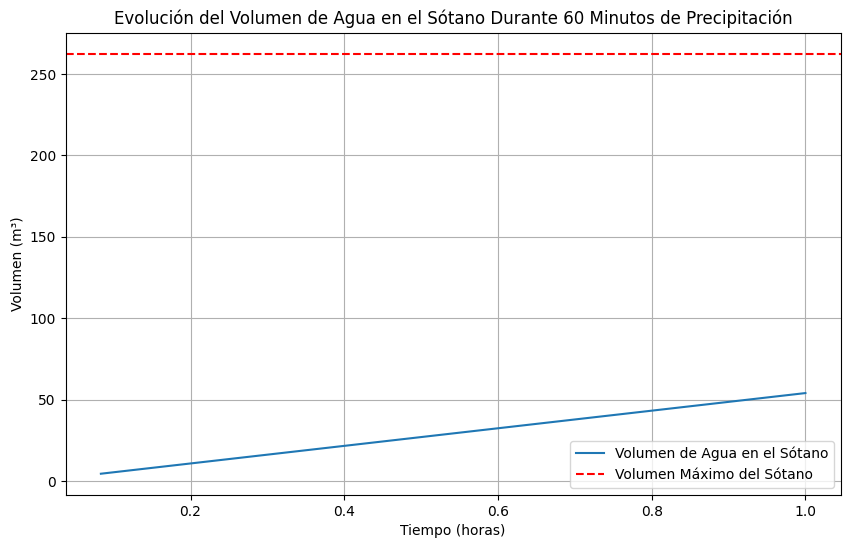

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(times, volumes, label='Volumen de Agua en el Sótano')
plt.axhline(y=V_SOT, color='r', linestyle='--', label='Volumen Máximo del Sótano')
plt.xlabel('Tiempo (horas)')
plt.ylabel('Volumen (m³)')
plt.title('Evolución del Volumen de Agua en el Sótano Durante 60 Minutos de Precipitación')
plt.legend()
plt.grid(True)
plt.show()

## A.2

Discretizar las ec. 1 y ec. 6 con el método de Euler, considerando $C$ y $Q_{sal}$ variables. Correr
el modelo para todas las duraciónes / intensidades de precipitación, un lapso de tiempo
suficiente como para que el sótano se vacíe

In [4]:
storms_min_mm = [       # min, mm/h
    (5, 241.4),
    (10, 190.7),
    (15, 162.6),
    (30, 119.6),
    (60, 85.0),
    (180, 41.7),
    (360, 26.4),
    (720, 16.7),
    (1440, 10.9),
    (4320, 5.2),
]

storms = [(duration/60, intensity/1000) for duration, intensity in storms_min_mm]

storms_history = []

def d_volume(time, water_volume, infiltration, intensity):
    terrain_area = A_TERR

    max_flow = Q_MAX
    max_height_variation = D_H_MAX
    min_height_variation = D_H_MIN
    
    sotane_height = H_SOT
    
    sotane_area = A_SOT
    water_height = f_h(water_volume, sotane_area)

    heigth_variation = f_d_h(sotane_height, water_height)

    entry_flow = f_q_ent(infiltration, intensity, terrain_area)

    if water_height > 0:
        exit_flow = f_q_sal(max_flow, max_height_variation, min_height_variation, heigth_variation)
    else:
        exit_flow = 0

    return f_der_v(entry_flow, exit_flow)

def d_infiltration(t, volume, infiltration):

    sotane_volume = V_SOT

    caracteristic_time = T_K
    saturation_infiltration = C_SAT

    return f_der_c(volume, sotane_volume, caracteristic_time, saturation_infiltration, infiltration)

for storm_duration, storm_intensity in storms:

    print(f"Starting storm with {storm_intensity*1000} mm/h for {storm_duration*60} min")

    volumes = []
    infiltrations = []

    time = 0
    
    volume = 0
    volumes.append(volume)

    infiltration = C_0
    infiltrations.append(infiltration)

    d_time = storm_duration / 100

    while time < storm_duration:
        volume = volume + d_time * d_volume(time, volume, infiltration, storm_intensity)
        infiltration = infiltration + d_time * d_infiltration(time, volume, infiltration)
        volumes.append(volume)
        infiltrations.append(infiltration)
        time += d_time

    print(f"Storm finish and sotane has {round(volume,2)} m3")

    while volume > 0:
        volume = volume + d_time * d_volume(time, volume, infiltration, 0)
        infiltration = infiltration + d_time * d_infiltration(time, volume, infiltration)
        volumes.append(volume)
        infiltrations.append(infiltration)
        time += d_time

    print(f"Empyting sotane after {round(time*60,2)} min")
    print("")

    storms_history.append((storm_duration, storm_intensity, volumes, infiltrations, d_time))


Starting storm with 241.4 mm/h for 5.0 min
Storm finish and sotane has 7.59 m3
Empyting sotane after 570.7 min

Starting storm with 190.7 mm/h for 10.0 min
Storm finish and sotane has 11.94 m3
Empyting sotane after 719.2 min

Starting storm with 162.6 mm/h for 15.0 min
Storm finish and sotane has 15.22 m3
Empyting sotane after 815.55 min

Starting storm with 119.6 mm/h for 30.0 min
Storm finish and sotane has 22.27 m3
Empyting sotane after 997.8 min

Starting storm with 85.0 mm/h for 60.0 min
Storm finish and sotane has 31.65 m3
Empyting sotane after 1213.2 min

Starting storm with 41.7 mm/h for 180.0 min
Storm finish and sotane has 47.37 m3
Empyting sotane after 1589.4 min

Starting storm with 26.4 mm/h for 360.0 min
Storm finish and sotane has 58.63 m3
Empyting sotane after 1926.0 min

Starting storm with 16.7 mm/h for 720.0 min
Storm finish and sotane has 65.14 m3
Empyting sotane after 2361.6 min

Starting storm with 10.9 mm/h for 1440.0 min
Storm finish and sotane has 62.0 m3
Empyt

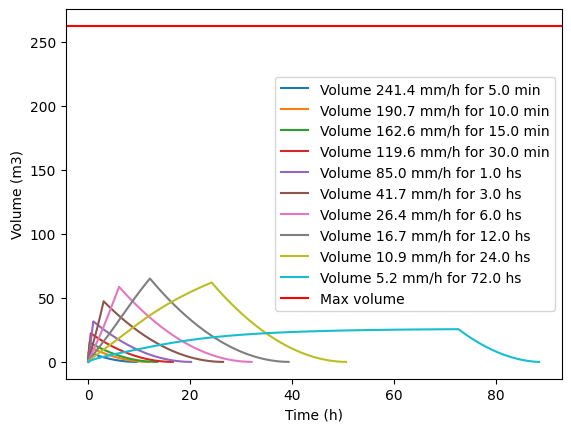

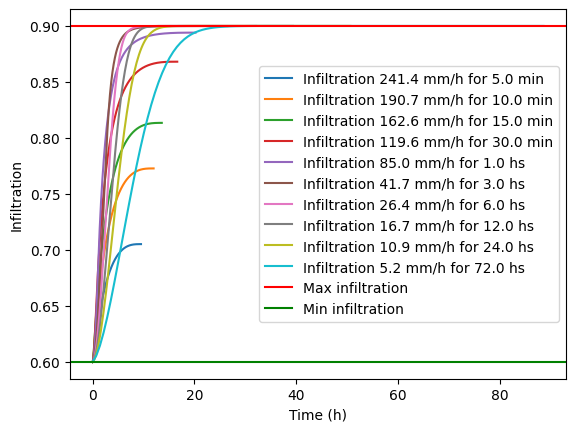

In [5]:
import matplotlib.pyplot as plt

for storm_duration, storm_intensity, volumes, infiltrations, d_time in storms_history:
        times = [i*d_time for i in range(len(volumes))]
        if storm_duration >= 1:
                plt.plot(times, volumes, label=f"Volume {storm_intensity*1000} mm/h for {storm_duration} hs")
        else:
                plt.plot(times, volumes, label=f"Volume {storm_intensity*1000} mm/h for {storm_duration*60} min")

plt.axhline(y=V_SOT, color='r', linestyle='-', label="Max volume")
plt.xlabel("Time (h)")
plt.ylabel("Volume (m3)")
plt.legend()
plt.show()

for storm_duration, storm_intensity, volumes, infiltrations, d_time in storms_history:
        times = [i*d_time for i in range(len(infiltrations))]
        if storm_duration >= 1:
                plt.plot(times, infiltrations, label=f"Infiltration {storm_intensity*1000} mm/h for {storm_duration} hs")
        else:
                plt.plot(times, infiltrations, label=f"Infiltration {storm_intensity*1000} mm/h for {storm_duration*60} min")

plt.axhline(y=C_SAT, color='r', linestyle='-', label="Max infiltration")
plt.axhline(y=C_0, color='g', linestyle='-', label="Min infiltration")
plt.xlabel("Time (h)")
plt.ylabel("Infiltration")
plt.legend()
plt.show()

## B 

Dimensionamiento de la bomba. Redimensionar la bomba adoptando un nuevo 𝑄_max
para que la altura de agua sobre el piso del sótano no exceda los 0,25m para ninguna de las precipitaciones de la tabla.

In [6]:
# Q_MAX inicial 
Q_MAX = 1

# incremento de Q_MAX en cada paso
increment = 1

# Maxima altura de agua en el sotano
max_water_height = 0.25

while True:
    print(f"Trying with Q_MAX = {Q_MAX}")

    storms_history = []

    for storm_duration, storm_intensity in storms:
        print(f"Starting storm with {storm_intensity*1000} mm/h for {storm_duration*60} min")

        volumes = []
        infiltrations = []

        time = 0

        volume = 0
        volumes.append(volume)

        infiltration = C_0
        infiltrations.append(infiltration)

        d_time = storm_duration / 100

        while time < storm_duration:
            volume = volume + d_time * d_volume(time, volume, infiltration, storm_intensity)
            infiltration = infiltration + d_time * d_infiltration(time, volume, infiltration)
            volumes.append(volume)
            infiltrations.append(infiltration)
            time += d_time

            water_height = f_h(volume, A_SOT)

            if water_height > max_water_height:
                break

        if water_height > max_water_height:
            break

        print(f"Storm finish and sotane has {round(volume,2)} m3")

        while volume > 0:
            volume = volume + d_time * d_volume(time, volume, infiltration, 0)
            infiltration = infiltration + d_time * d_infiltration(time, volume, infiltration)
            volumes.append(volume)
            infiltrations.append(infiltration)
            time += d_time

        print(f"Empyting sotane after {round(time*60,2)} min")
        print("")

        storms_history.append((storm_duration, storm_intensity, volumes, infiltrations, d_time))

    if water_height <= max_water_height:
        break

    Q_MAX += increment

print(f"Found Q_MAX = {Q_MAX} that ensures the water height never exceeds {max_water_height}m for all storms")

Trying with Q_MAX = 1
Starting storm with 241.4 mm/h for 5.0 min
Storm finish and sotane has 7.67 m3
Empyting sotane after 4555.2 min

Starting storm with 190.7 mm/h for 10.0 min
Storm finish and sotane has 12.13 m3
Empyting sotane after 5732.6 min

Starting storm with 162.6 mm/h for 15.0 min
Storm finish and sotane has 15.55 m3
Empyting sotane after 6492.9 min

Starting storm with 119.6 mm/h for 30.0 min
Trying with Q_MAX = 2
Starting storm with 241.4 mm/h for 5.0 min
Storm finish and sotane has 7.66 m3
Empyting sotane after 2278.3 min

Starting storm with 190.7 mm/h for 10.0 min
Storm finish and sotane has 12.1 m3
Empyting sotane after 2867.7 min

Starting storm with 162.6 mm/h for 15.0 min
Storm finish and sotane has 15.5 m3
Empyting sotane after 3248.7 min

Starting storm with 119.6 mm/h for 30.0 min
Trying with Q_MAX = 3
Starting storm with 241.4 mm/h for 5.0 min
Storm finish and sotane has 7.65 m3
Empyting sotane after 1519.35 min

Starting storm with 190.7 mm/h for 10.0 min
Stor